<a href="https://colab.research.google.com/github/mahshadmoradi/DL/blob/main/BERT_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-tuning BERT on SubtaskB dataset

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
import sentencepiece
import torch
import numpy as np
import random
import json
import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np
import math
import torch
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
import gc
import time
import datetime

In [ ]:
#Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


##Data preparation

In [ ]:
%%capture
!pip install gdown
import gdown

id = "11YeloR2eTXcTzdwI04Z-M2QVvIeQAU6-"
gdown.download_folder(id=id, quiet=True, use_cookies=False)

In [ ]:
# # File paths
# train_file = "/content/drive/MyDrive/DL-project/Dataset/subtaskB_train.jsonl"
# dev_file = "/content/drive/MyDrive/DL-project/Dataset/subtaskB_dev.jsonl"

# # Load the dataset
# dataset = load_dataset("json", data_files={"train": train_file, "dev": dev_file})

In [ ]:
# Open the JSONL file and read its contents
with open('/kaggle/working/SubtaskB/subtaskB_train.jsonl', 'r') as file:
    lines = file.readlines()

# Parse each line as a JSON object
train_objects = [json.loads(line) for line in lines]

In [ ]:
# print(train_objects[199])

In [ ]:
with open('/kaggle/working/SubtaskB/subtaskB_dev.jsonl', 'r') as file:
    lines = file.readlines()

dev_objects = [json.loads(line) for line in lines]

In [ ]:
def create_balanced_dataset(data, target_size_percentage, labels=[0, 1, 2, 3, 4, 5]):
    # Filter data by labels
    data_by_label = {label: [item for item in data if item['label'] == label] for label in labels}

    # Calculate the number of samples per label
    total_samples = int(len(data) * target_size_percentage / len(labels))
    balanced_data = []

    # Select an equal number of samples from each label group
    for label in labels:
        balanced_data.extend(random.sample(data_by_label[label], total_samples))

    # Shuffle the dataset
    random.shuffle(balanced_data)

    return balanced_data

In [ ]:
# # Create the balanced dataset
# balanced_dataset = create_balanced_dataset(train_objects, 0.50)  # 20% of the original size

# # Print the first 5 samples to check their structure
# print("First 5 samples:", balanced_dataset[:5])

# # Check the length of the dataset
# print("Total number of samples in the balanced dataset:", len(balanced_dataset))

# # Check the label distribution
# label_count = {label: sum(item['label'] == label for item in balanced_dataset) for label in [0, 1, 2, 3, 4, 5]}
# print("Label distribution:", label_count)

# # Optionally, inspect specific entries by their index
# index_to_check = 10
# print("Sample at index 10:", balanced_dataset[index_to_check])

In [ ]:
  # id -> identifier of the example,
  # label -> label (human: 0, chatGPT: 1, cohere: 2, davinci: 3, bloomz: 4, dolly: 5),
  # text -> text generated by machine or written by human,
  # model -> model name that generated data,
  # source -> source (Wikipedia, Wikihow, Peerread, Reddit, Arxiv) on English

In [ ]:
learning_rate = 1e-6
num_classes = 6
max_seq_length = 128
label_list = list(range(6))
batch_size = 32

In [ ]:
class SemEval_Dataset(Dataset):
    def __init__(self, json_file, label_list, max_seq_length, tokenizer, dtype=torch.long):
        self.json_file = json_file
        self.dtype = dtype
        self.label_list = label_list  # [0, 1, 2, 3, 4, 5]
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.json_file)

    def feature_extractor(self, text, label=None):
        tokenized_text = self.tokenizer(text, add_special_tokens=True, padding='max_length', truncation=True, max_length=self.max_seq_length, return_tensors="pt")
        input_ids = tokenized_text['input_ids']
        attention_mask = tokenized_text['attention_mask']

        label = torch.tensor(label, dtype=self.dtype)
        return input_ids, attention_mask, label

    def __getitem__(self, idx):
        data = self.json_file[idx]
        input_ids, attention_mask, label = self.feature_extractor(data['text'], label=data['label'])

        return input_ids.squeeze(0), attention_mask.squeeze(0), label

##Model

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'roberta-large'
tokenizer = RobertaTokenizer.from_pretrained(model_name)
bert_model = RobertaModel.from_pretrained(model_name)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# tokenizer

In [ ]:
class BertForClassification(nn.Module):
    def __init__(self, bert_modele):
        super(BertForClassification, self).__init__()
        self.bert = bert_modele
#         self.dropout = torch.nn.Dropout(0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(256, 6)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output # return embedding of 'CLS' token for classification.
#         pooled_output = self.dropout(pooled_output)
        output = self.relu(self.linear(pooled_output))
        return self.classifier(output)

In [ ]:
# import copy

# model = BertForClassification(bert_model)
# model = nn.DataParallel(model).to(device)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(model_name)

dev_dataset = SemEval_Dataset(dev_objects, label_list, max_seq_length, tokenizer, dtype=torch.long)
dev_dataloader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(model_name)

def create_dataset(percentage):
    traindata = create_balanced_dataset(train_objects, percentage)
    train_dataset = SemEval_Dataset(traindata, label_list, max_seq_length, tokenizer, dtype=torch.long)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    return train_dataloader


##Train and Evaluation

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from sklearn.metrics import f1_score

def train_evaluate(model, train_dataloader, dev_dataloader, num_train_epochs, return_loss=False):

    start_time = time.time()  # Record the start time

    if return_loss:
        train_loss_per_epoch = []
        val_loss_per_epoch = []
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch_num in range(num_train_epochs):
        print('Epoch: ', epoch_num + 1)
        train_accuracy, train_loss = train_epoch(model, train_dataloader, loss_fn, optimizer)
        valid_accuracy, valid_loss = evaluate(model, dev_dataloader)

        # Print results for the epoch
        print("Train Accuracy: {0:.4f} ".format(train_accuracy))
        print("Train Loss: {0:.4f} ".format(train_loss))
        print("Validation Accuracy: {0:.4f} ".format(valid_accuracy))
        print("Validation Loss: {0:.4f} \n ".format(valid_loss))

        if return_loss:
            train_loss_per_epoch.append(train_loss)
            val_loss_per_epoch.append(valid_loss)

    end_time = time.time()  # Record the end time
    total_time = end_time - start_time  # Calculate total duration
    formatted_time = format_time(total_time)
    print(f"Training and evaluation time: {formatted_time} ")

    if return_loss:
        return train_loss_per_epoch, val_loss_per_epoch

def train_epoch(model, train_dataloader, loss_fn, optimizer):
    # Training
    model.train()
    train_loss = 0
    correct_train_predictions = 0
    total_train_predictions = 0

    for step_num, batch_data in enumerate(tqdm(train_dataloader, desc='Training')):
        torch.cuda.empty_cache()
        gc.collect()
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=att_mask)
        loss = loss_fn(outputs, labels)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, dim=1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

        # Backward pass and optimization
        train_loss += loss.item()
        model.zero_grad()
        loss.backward()
        optimizer.step()

        for data in batch_data:
            data.cpu()

    average_train_accuracy = correct_train_predictions / total_train_predictions

    return average_train_accuracy, train_loss / len(train_dataloader)

def evaluate(model, dev_dataloader, return_pred_labels=False):
        loss_fn = torch.nn.CrossEntropyLoss()
        model.eval()
        valid_loss = 0
        correct_val_predictions = 0
        total_val_predictions = 0
        valid_pred = []
        valid_labels = []

        with torch.no_grad():
            for step_num_e, batch_data in enumerate(tqdm(dev_dataloader, desc='Validation')):
                torch.cuda.empty_cache()
                gc.collect()
                input_ids, att_mask, labels = [data.to(device) for data in batch_data]

                # Forward pass
                outputs = model(input_ids=input_ids, attention_mask=att_mask)
                loss = loss_fn(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, dim=1)
                valid_pred.append(predicted.cpu().numpy())
                valid_labels.append(labels.cpu().numpy())

                correct_val_predictions += (predicted == labels).sum().item()
                total_val_predictions += labels.size(0)
                for data in batch_data:
                    data.cpu()

        average_val_accuracy = correct_val_predictions / total_val_predictions
        valid_pred = np.concatenate(valid_pred)
        valid_labels = np.concatenate(valid_labels)

        if return_pred_labels:
            return average_val_accuracy, valid_loss / len(dev_dataloader), valid_pred, valid_labels
        else:
            return average_val_accuracy, valid_loss / len(dev_dataloader)

## Percent 1

In [ ]:
model_1 = BertForClassification(bert_model)
model_1 = nn.DataParallel(model_1).to(device)

In [ ]:
train_loader_1 = create_dataset(0.01)

In [ ]:
train_evaluate(model_1, train_loader_1, dev_dataloader, 10)

Epoch:  1


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.2161 
Train Loss: 1.7681 
Validation Accuracy: 0.2600 
Validation Loss: 1.7608 
 
Epoch:  2


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.3192 
Train Loss: 1.7260 
Validation Accuracy: 0.3943 
Validation Loss: 1.7050 
 
Epoch:  3


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.3969 
Train Loss: 1.6941 
Validation Accuracy: 0.4337 
Validation Loss: 1.6721 
 
Epoch:  4


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.4506 
Train Loss: 1.6625 
Validation Accuracy: 0.4420 
Validation Loss: 1.6455 
 
Epoch:  5


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.4986 
Train Loss: 1.6302 
Validation Accuracy: 0.4720 
Validation Loss: 1.6076 
 
Epoch:  6


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.5000 
Train Loss: 1.6024 
Validation Accuracy: 0.4887 
Validation Loss: 1.5793 
 
Epoch:  7


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.5212 
Train Loss: 1.5693 
Validation Accuracy: 0.5003 
Validation Loss: 1.5531 
 
Epoch:  8


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.5381 
Train Loss: 1.5296 
Validation Accuracy: 0.5477 
Validation Loss: 1.5230 
 
Epoch:  9


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.5819 
Train Loss: 1.5040 
Validation Accuracy: 0.5550 
Validation Loss: 1.5051 
 
Epoch:  10


Training:   0%|          | 0/23 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.6003 
Train Loss: 1.4794 
Validation Accuracy: 0.5473 
Validation Loss: 1.4761 
 
Training and evaluation time: 0:20:07 


In [ ]:
valid_loss, valid_acc, valid_pred_1, valid_labels = evaluate(model_1, dev_dataloader, return_pred_labels=True)

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
import torch
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(valid_labels, valid_pred_1)
print(f"Validation Accuracy: {accuracy}")

# label_names = [f"Class {label}" for label in valid_labels]

# Now generate the classification report
print('Classification Report:')
print(classification_report(valid_pred_1, valid_labels,))

Validation Accuracy: 0.5473333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.61      0.60       481
           1       0.16      0.68      0.26       117
           2       0.86      0.34      0.49      1277
           3       0.00      0.00      0.00        49
           4       0.82      0.73      0.77       562
           5       0.86      0.84      0.85       514

    accuracy                           0.55      3000
   macro avg       0.55      0.53      0.49      3000
weighted avg       0.77      0.55      0.60      3000



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

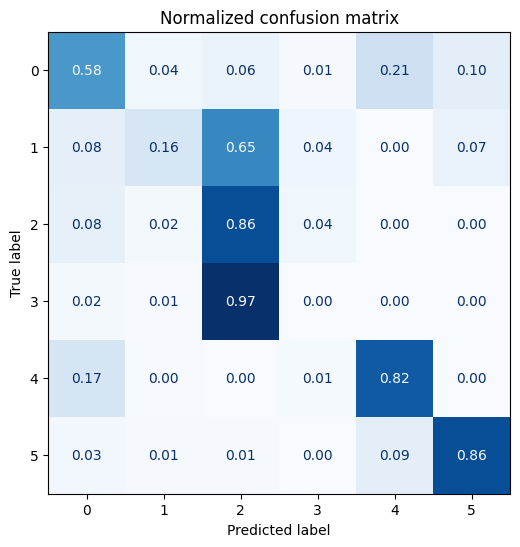

In [ ]:
plot_confusion_matrix(valid_pred_1, valid_labels)

In [ ]:
with open('valid_1.txt', 'wb') as f:
    np.save(f, np.array(valid_pred_1))

## Percent 5

In [ ]:
model_5 = BertForClassification(bert_model)
model_5 = nn.DataParallel(model_5).to(device)

In [ ]:
train_loader_5 = create_dataset(0.05)

In [ ]:
train_evaluate(model_5, train_loader_5, dev_dataloader, 7)

Epoch:  1


Training:   0%|          | 0/111 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.7321 
Train Loss: 1.4060 
Validation Accuracy: 0.5107 
Validation Loss: 1.4235 
 
Epoch:  2


Training:   0%|          | 0/111 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.8875 
Train Loss: 0.9526 
Validation Accuracy: 0.6010 
Validation Loss: 1.2150 
 
Epoch:  3


Training:   0%|          | 0/111 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.8999 
Train Loss: 0.7201 
Validation Accuracy: 0.5360 
Validation Loss: 1.3435 
 
Epoch:  4


Training:   0%|          | 0/111 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9222 
Train Loss: 0.5614 
Validation Accuracy: 0.6030 
Validation Loss: 1.1865 
 
Epoch:  5


Training:   0%|          | 0/111 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9284 
Train Loss: 0.4630 
Validation Accuracy: 0.5863 
Validation Loss: 1.2758 
 
Epoch:  6


Training:   0%|          | 0/111 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9433 
Train Loss: 0.3842 
Validation Accuracy: 0.6187 
Validation Loss: 1.2389 
 
Epoch:  7


Training:   0%|          | 0/111 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9521 
Train Loss: 0.3238 
Validation Accuracy: 0.6010 
Validation Loss: 1.2904 
 
Training and evaluation time: 0:34:56 


In [ ]:
valid_loss, valid_acc, valid_pred_5, valid_labels = evaluate(model_5, dev_dataloader, return_pred_labels=True)

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
accuracy = accuracy_score(valid_labels, valid_pred_5)
print(f"Validation Accuracy: {accuracy}")

# Now generate the classification report
print('Classification Report:')
print(classification_report(valid_pred_5, valid_labels,))

Validation Accuracy: 0.601
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.92      0.55       213
           1       0.72      0.72      0.72       502
           2       0.89      0.43      0.58      1033
           3       0.05      0.08      0.06       324
           4       0.96      0.86      0.91       558
           5       0.59      0.79      0.68       370

    accuracy                           0.60      3000
   macro avg       0.60      0.63      0.58      3000
weighted avg       0.71      0.60      0.62      3000



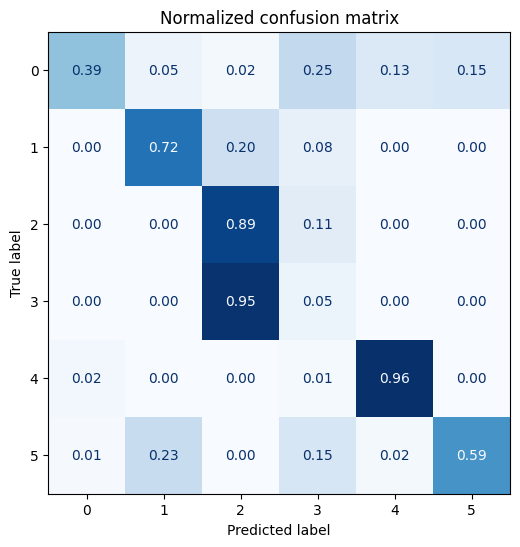

In [ ]:
plot_confusion_matrix(valid_pred_5, valid_labels)

In [ ]:
with open('valid_5.txt', 'wb') as f:
    np.save(f, np.array(valid_pred_5))

## Percent 10

In [ ]:
model_10 = BertForClassification(bert_model)
model_10 = nn.DataParallel(model_10).to(device)

In [ ]:
train_loader_10 = create_dataset(0.1)

In [ ]:
train_evaluate(model_10, train_loader_10, dev_dataloader, 7)

Epoch:  1


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.8567 
Train Loss: 1.0921 
Validation Accuracy: 0.6270 
Validation Loss: 1.1494 
 
Epoch:  2


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9232 
Train Loss: 0.5631 
Validation Accuracy: 0.6283 
Validation Loss: 1.0932 
 
Epoch:  3


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9376 
Train Loss: 0.3822 
Validation Accuracy: 0.5847 
Validation Loss: 1.2636 
 
Epoch:  4


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9511 
Train Loss: 0.2884 
Validation Accuracy: 0.6160 
Validation Loss: 1.2003 
 
Epoch:  5


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9597 
Train Loss: 0.2281 
Validation Accuracy: 0.6290 
Validation Loss: 1.2364 
 
Epoch:  6


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9645 
Train Loss: 0.1906 
Validation Accuracy: 0.6063 
Validation Loss: 1.3818 
 
Epoch:  7


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

Train Accuracy: 0.9721 
Train Loss: 0.1545 
Validation Accuracy: 0.6210 
Validation Loss: 1.3729 
 
Training and evaluation time: 1:00:13 


In [ ]:
valid_loss, valid_acc, valid_pred_10, valid_labels = evaluate(model_10, dev_dataloader, return_pred_labels=True)

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
import torch
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(valid_labels, valid_pred_10)
print(f"Validation Accuracy: {accuracy}")

# Now generate the classification report
print('Classification Report:')
print(classification_report(valid_pred_10, valid_labels,))

Validation Accuracy: 0.621
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.98      0.59       217
           1       0.69      0.88      0.77       393
           2       0.91      0.43      0.58      1053
           3       0.04      0.05      0.04       328
           4       1.00      0.83      0.90       604
           5       0.67      0.82      0.74       405

    accuracy                           0.62      3000
   macro avg       0.62      0.67      0.61      3000
weighted avg       0.73      0.62      0.64      3000



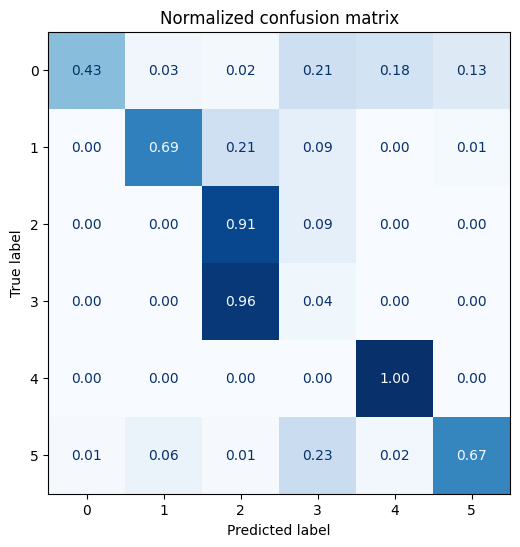

In [ ]:
plot_confusion_matrix(valid_pred_10, valid_labels)

In [ ]:
with open('valid_10.txt', 'wb') as f:
    np.save(f, np.array(valid_pred_10))

## Percent 50

In [ ]:
model_50 = BertForClassification(bert_model)
model_50 = nn.DataParallel(model_50).to(device)

In [ ]:
train_loader_50 = create_dataset(0.5)

In [ ]:
train_evaluate(model_50, train_loader_50, dev_dataloader, 7)

In [ ]:
valid_loss, valid_acc, valid_pred_50, valid_labels = evaluate(model_50, dev_dataloader, return_pred_labels=True)

Validation:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
import torch
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(valid_labels, valid_pred_50)
print(f"Validation Accuracy: {accuracy}")

# Now generate the classification report
print('Classification Report:')
print(classification_report(valid_pred_50, valid_labels,))

Validation Accuracy: 0.6633333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.99      0.55       193
           1       0.90      0.82      0.86       547
           2       0.86      0.45      0.59       948
           3       0.05      0.12      0.07       231
           4       1.00      0.82      0.90       607
           5       0.79      0.83      0.81       474

    accuracy                           0.66      3000
   macro avg       0.66      0.67      0.63      3000
weighted avg       0.79      0.66      0.70      3000



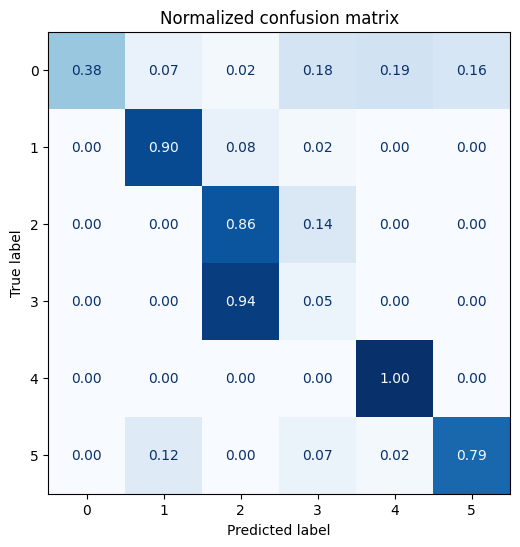

In [ ]:
plot_confusion_matrix(valid_pred_50, valid_labels)

In [ ]:
with open('valid_50.txt', 'wb') as f:
    np.save(f, np.array(valid_pred_50))

##Results

In [ ]:
with open('valid_1.txt', 'rb') as f:
    valid_pred_1 = np.load(f)
with open('valid_5.txt', 'rb') as f:
    valid_pred_5 = np.load(f)
with open('valid_10.txt', 'rb') as f:
    valid_pred_10 = np.load(f)
with open('valid_50.txt', 'rb') as f:
    valid_pred_50 = np.load(f)

In [ ]:
accuracies = []
f1_scores = []

accuracies.append(accuracy_score(valid_labels, valid_pred_1))
f1_scores.append(classification_report(valid_pred_1, valid_labels))

accuracies.append(accuracy_score(valid_labels, valid_pred_5))
f1_scores.append(classification_report(valid_pred_5, valid_labels))

accuracies.append(accuracy_score(valid_labels, valid_pred_10))
f1_scores.append(classification_report(valid_pred_10, valid_labels))

accuracies.append(accuracy_score(valid_labels, valid_pred_50))
f1_scores.append(classification_report(valid_pred_50, valid_labels))

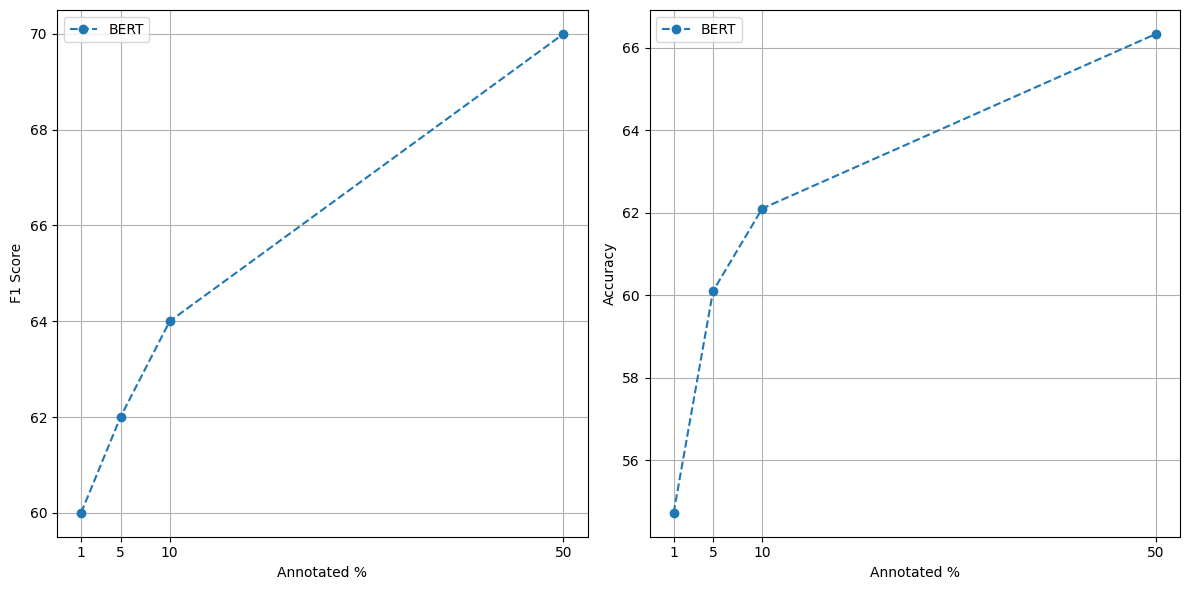

In [ ]:
import matplotlib.pyplot as plt

ps = [1, 5, 10, 50]

# Creating two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot F1 Scores
ax1.plot(ps, f1_scores, 'o--', label='BERT')
ax1.set_xscale('linear')  # Change to linear scale if you prefer
ax1.set_xticks(ps)  # Set the ticks to be at the percentages
ax1.set_xlabel('Annotated %')
ax1.set_ylabel('F1 Score')
ax1.grid(True)  # Add grid for better readability

# Plot Accuracy
ax2.plot(ps, accuracies, 'o--', label='BERT')
ax2.set_xscale('linear')  # Change to linear scale if you prefer
ax2.set_xticks(ps)  # Set the ticks to be at the percentages
ax2.set_xlabel('Annotated %')
ax2.set_ylabel('Accuracy')
ax2.grid(True)  # Add grid for better readability

# Adjust subplot layout and add legends
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()